Here there is the complete and fully functional implementation of the learnable prompt, either it is positive or negative, can pass thorugh this module and we have a learnable context. We will use this as the embedding input of the instruct-pix2pix model 


Next steps:

- [ ] Implement the full attack class constructing the right connection between the learnable prompt in the instruct-pix2pix model and the instruct-pix2pix in the dino-small model.

- [x] Test if the learnable prompt with 0 context and a random prompt injected in the model vs. the model with the same random prompt lead to similar output (cannot achieve same as the sampling is not deterministic) or we can directly check their embeddings.

- [ ] Devise which strategy to use to train the learnable prompt (one prompt for each image? same prompt for different images of the same class? ) and build the train function.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip

class LearnablePrompt(nn.Module):
    """
    A trainable prompt representation for the Instruct-Pix2Pix model.
    We want to learn a set of parameters that can be used to generate
    a text prompt for the diffusion model. The parameters are optimized
    during training to attack the representation space of the diffusion model.
    """
    def __init__(self, device, clip_model, template="Make the image: ", 
                 ctx_len=10):
        super().__init__()
        self.device = device
        self.template = template
        self.clip_model = clip_model
        self.tokenizer = clip.tokenize
        
        # Freezing the text encoder - we're only learning the parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False
            

        self.ctx_len = ctx_len
        self.max_length = 77
        self.embedding_dim = self.clip_model.token_embedding.weight.shape[1]
        self.dtype = self.clip_model.dtype

        # Initialize context parameters
        self.context = nn.Parameter(torch.randn(1, ctx_len, self.embedding_dim, device=self.device, dtype=self.dtype ) * 0.02)

        # Pre-compute template tokens
        self.template_tokens = self.tokenizer(self.template).to(self.device)

        # Get the position of the EOS token in the template
        mask = self.template_tokens[0] == 49407
        eos_idx = int(torch.nonzero(mask).squeeze())

        self.prefix_embed = self.clip_model.token_embedding(self.template_tokens)[:, :eos_idx].detach().type(self.dtype) #[SOS] + template
        self.eos_embed = self.clip_model.token_embedding(self.template_tokens)[:, eos_idx:].detach().type(self.dtype)    #[EOS]

        # Calculate total sequence length
        self.total_length = eos_idx + ctx_len + 1  # SOS + template + ctx + EOS

        #This is just a mask for getting the position of the eos token
        self.tokenized_prompt = torch.zeros(1, self.max_length, device = self.device)
        self.tokenized_prompt[: , self.total_length - 1] = 1

        if self.total_length > self.max_length:
            print(
                f"Warning: Total sequence length ({self.total_length}) exceeds maximum length ({self.max_length}). "
                "Sequence will be truncated."
            )
        
    def get_params_snapshot(self):
        """Get the current parameter values"""
        return self.context.detach().cpu().numpy()
    
    def _encode_prompt(self, full_embeddings):
        full_embeddings = full_embeddings + self.clip_model.positional_embedding.type(self.dtype)
        full_embeddings = full_embeddings.permute(1, 0, 2) # [batch_size, seq_len, dim] -> [seq_len, batch_size, dim]
        full_embeddings = self.clip_model.transformer(full_embeddings)
        full_embeddings = full_embeddings.permute(1, 0, 2) # [seq_len, batch_size, dim] -> [batch_size, seq_len, dim]
        full_embeddings = self.clip_model.ln_final(full_embeddings) #.type(self.dtype)

        #return full_embeddings[torch.arange(full_embeddings.shape[0], device=full_embeddings.device), self.tokenized_prompt.argmax(dim=-1)] @ self.clip_model.text_projection

        return full_embeddings
    
    def _build_full_embeddings(self):
        # Combine all embeddings: [SOS] + template + ctx + [EOS]
        return torch.cat([
            self.prefix_embed,
            self.context,
            self.eos_embed,
        ], dim=1)[:, :77]
        
    def forward(self):
        """
        Returns the text embeddings with structure: [SOS] + template + ctx + [EOS]
        
        Returns:
            display_prompt (str): Text representation of the prompt (for display)
            text_embeddings (torch.Tensor): Complete text embeddings
        """
        # Combine all embeddings: [SOS] + template + ctx + [EOS]
        full_embeddings = self._build_full_embeddings()
        # Encode the prompt
        output = self._encode_prompt(full_embeddings)
        
        return output

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
clip_model= clip.load("ViT-L/14", device=device)[0]

In [33]:
trial = LearnablePrompt(
    device=device, 
    template="Make the image: ", 
    ctx_len=10, 
    clip_model = clip_model
)

In [34]:
trial().shape

torch.Size([1, 77, 768])

In [35]:
trial._build_full_embeddings().shape

torch.Size([1, 77, 768])

In [36]:
# Initialize the model
from diffusers import StableDiffusionInstructPix2PixPipeline
import torch
model = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    safety_checker=None,
).to("cuda" if torch.cuda.is_available() else "cpu")

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.00it/s]


In [61]:
from prompt_tuning_attack.src.utils import open_image, display_image

image = open_image("zebra.jpg")
output = model(
    "make the zebra red",
    image=  image,
    num_inference_steps=50,
    guidance_scale=7.5,
    negative_prompt="bad quality, blurry, low resolution"
)

100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


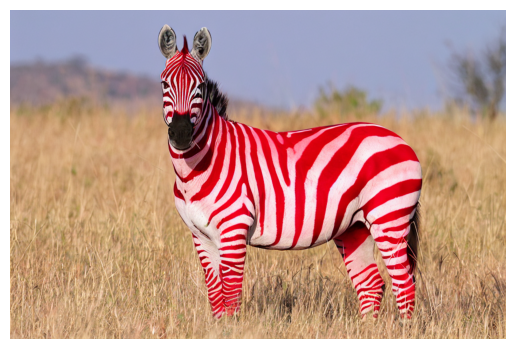

In [62]:
display_image(output.images[0])

In [96]:
type(clip_model)

clip.model.CLIP

In [93]:
trial_prompt = LearnablePrompt(
    device=device, 
    template="Change the color of the zebra to: red", 
    ctx_len=10, 
    clip_model = clip_model
)

trial_negative_prompt = LearnablePrompt(
    device=device, 
    template="bad quality, blurry, low resolution", 
    ctx_len=0, 
    clip_model = clip_model
)

In [94]:
output2 = model(
    prompt_embeds = trial_prompt(),
    image=  image,
    num_inference_steps=50,
    guidance_scale=7.5,
    negative_embeds = trial_negative_prompt(),
)

100%|██████████| 50/50 [00:09<00:00,  5.55it/s]


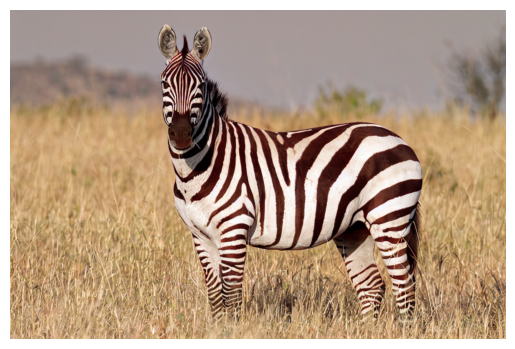

In [95]:
display_image(output2.images[0])